In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import numpy as np

import matplotlib.pyplot as plt
import urllib.request

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from math import trunc
import datetime

import statsmodels.api as sm
import pyflux as pf

#import keras
#from keras import backend as K
#import theano

## Loading datasets
Source: [All GDELT Event Files](http://data.gdeltproject.org/events/index.html)

Datasets are zip .csv files created every day from 2013-04-01 until now. The following code creates .csv files on the local machine, but every file represents data for a whole month.

In [25]:
# Create list of headers
headers = ['GLOBALEVENTID',
           'SQLDATE',
           'MonthYear',
           'Year',
           'FractionDate',
           'Actor1Code',
           'Actor1Name',
           'Actor1CountryCode',
           'Actor1KnownGroupCode',
           'Actor1EthnicCode',
           'Actor1Religion1Code',
           'Actor1Religion2Code',
           'Actor1Type1Code',
           'Actor1Type2Code',
           'Actor1Type3Code',
           'Actor2Code',
           'Actor2Name',
           'Actor2CountryCode',
           'Actor2KnownGroupCode',
           'Actor2EthnicCode',
           'Actor2Religion1Code',
           'Actor2Religion2Code',
           'Actor2Type1Code',
           'Actor2Type2Code',
           'Actor2Type3Code',
           'IsRootEvent',
           'EventCode',
           'EventBaseCode',
           'EventRootCode',
           'QuadClass',
           'GoldsteinScale',
           'NumMentions',
           'NumSources',
           'NumArticles',
           'AvgTone',
           'Actor1Geo_Type',
           'Actor1Geo_FullName',
           'Actor1Geo_CountryCode',
           'Actor1Geo_ADM1Code',
           'Actor1Geo_Lat',
           'Actor1Geo_Long',
           'Actor1Geo_FeatureID',
           'Actor2Geo_Type',
           'Actor2Geo_FullName',
           'Actor2Geo_CountryCode',
           'Actor2Geo_ADM1Code',
           'Actor2Geo_Lat',
           'Actor2Geo_Long',
           'Actor2Geo_FeatureID',
           'ActionGeo_Type',
           'ActionGeo_FullName',
           'ActionGeo_CountryCode',
           'ActionGeo_ADM1Code',
           'ActionGeo_Lat',
           'ActionGeo_Long',
           'ActionGeo_FeatureID',
           'DATEADDED',
           'SOURCEURL']
# Create lists of all possible values of months and days
'''Years = ['2013', '2014', '2015', '2016']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31']'''

Years = ['2016']
Months = ['09']
Days = ['01', '02', '03']

# Reading datasets and writing them on the local machine
for i in Years:
    for j in Months:
        path1 = r'./dataset/' + i + j + r'.csv'
        Flag = True
        for k in Days:
            path = r'http://data.gdeltproject.org/events/' + i + j + k + r'.export.CSV.zip'
            try:
                local_filename, header = urllib.request.urlretrieve(path)
            except urllib.request.HTTPError:
                break
            if Flag:
                pd.read_csv(local_filename, sep = '\t', header = None, 
                        compression = 'zip', low_memory = False).to_csv(path1, 
                        index = False, header = headers)
                Flag = False
            else:
                pd.read_csv(local_filename, sep = '\t', header = None, 
                        compression = 'zip', low_memory = False).to_csv(path1, 
                        index = False, mode='a')

## Cleaning data
The following code provides:
* Exctracting information about events in certain country from files on a local machine
* Cleaning data from duplicates

In [2]:
# Loading data from the files on a local machine
Columns = ['SQLDATE', 
           'Year', 
           'FractionDate', 
           'Actor1Code',
           'Actor1Name', 
           'Actor1CountryCode', 
           'Actor2Code', 
           'Actor2Name',
           'Actor2CountryCode', 
           'IsRootEvent', 
           'EventCode', 
           'EventBaseCode',
           'EventRootCode', 
           'QuadClass', 
           'GoldsteinScale', 
           'NumMentions', 
           'NumSources', 
           'NumArticles', 
           'AvgTone',
           'Actor1Geo_Type',
           'Actor1Geo_FullName', 
           'Actor1Geo_CountryCode', 
           'Actor1Geo_Lat', 
           'Actor1Geo_Long',
           'Actor2Geo_Type', 
           'Actor2Geo_FullName', 
           'Actor2Geo_CountryCode', 
           'Actor2Geo_Lat', 
           'Actor2Geo_Long', 
           'ActionGeo_Type',
           'ActionGeo_FullName',
           'ActionGeo_CountryCode',
           'ActionGeo_Lat',
           'ActionGeo_Long',
           'DATEADDED',
           'SOURCEURL']
Years = ['2013', '2014', '2015', '2016']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

Country = 'FR'
Country1 = 'FRA'
Flag = True
path1 = r'./dataset/' + Country + r'.csv'

for i in Years:
    for j in Months:
        path = r'./dataset/' + i + j + r'.csv'
        try:
            DataSet = pd.read_csv(path, header = 0, index_col = 0)
        except OSError:
            continue
        DataSet = DataSet.loc[(( ( (DataSet['Actor1Geo_CountryCode'] == Country) | (DataSet['Actor2Geo_CountryCode'] == Country) ) 
                               & ( (DataSet['Actor1CountryCode'] == Country1) | (DataSet['Actor2CountryCode'] == Country1)))
                             | ( ( (DataSet['Actor1Geo_CountryCode'] == Country) | (DataSet['Actor2Geo_CountryCode'] == Country) ) 
                               & ( (DataSet['Actor1CountryCode'] != DataSet['Actor1CountryCode']) 
                                 & (DataSet['Actor2CountryCode'] != DataSet['Actor2CountryCode'])))),
                               Columns]
        # creating new columns 'AvgToneN' and 'FractionDateN' cleaning data from duplicates
        # 'AvgToneN' is 'AvgTone', but with less possible values
        # 'FractionDateN' is truncated 'FractionDate'
        x = []
        for k in DataSet['AvgTone']:
            if k<= -20: x.append(-25)
            elif (k > -20) and (k <= -15): x.append(-17)
            elif (k > -15) and (k <= -10): x.append(-12)
            elif (k > -10) and (k <= -5): x.append(-7)
            elif (k > -5) and (k <= 0): x.append(-2)
            elif (k > 0) and (k <= 5): x.append(3)
            elif (k > 5) and (k <= 10): x.append(8)
            elif (k > 10) and (k <= 15): x.append(13)
            elif (k > 15) and (k <= 20): x.append(18)
            else: x.append(25)
        DataSet['AvgToneN'] = x
        x = []
        for k in DataSet['FractionDate']:
            x.append(trunc(k*100)/100)
        DataSet['FractionDateN'] = x
        del x
        DataSet = DataSet.drop_duplicates('SOURCEURL')
        DataSet = DataSet.drop_duplicates(['FractionDateN',
                                           'QuadClass',
                                           'GoldsteinScale',
                                           'AvgToneN',
                                           'Actor1CountryCode',
                                           'Actor2CountryCode'])
        if Flag:
            DataSet.to_csv(path1, header = True)
            Flag = False
        else:
            DataSet.to_csv(path1, header = False, mode='a')
        del DataSet

path1 = r'./dataset/' + Country + r'.csv'
DataSet = pd.read_csv(path1, header = 0, index_col = 0, parse_dates = ['SQLDATE', 'DATEADDED'], 
                      infer_datetime_format = True)

# aggregating data. Every day has a lot of events. If event doesn't have event with AvgTone less than -15 
# and GoldsteinScale = -10 AvgTone is calculated as average of AvgTone all events in a certain day,
# otherwise - minimum AvgTone
Y = []
X = []
E = []
U = []
Lat = []
Long = []

# filling empty 'DATEADDED' values
l = len(DataSet['SQLDATE'])
for i in range(l):
    if DataSet.loc[DataSet.index[i], 'DATEADDED'] != DataSet.loc[DataSet.index[i], 'DATEADDED']:
        DataSet.loc[DataSet.index[i], 'DATEADDED'] = DataSet.loc[DataSet.index[i], 'SQLDATE']

DataSet = DataSet.sort_values(by = 'DATEADDED', ascending = True)
while (len(DataSet['DATEADDED']) > 0):
    Date = DataSet.loc[DataSet.index[0], 'DATEADDED']
    D = pd.DataFrame( [(0, 0, 0, '-', 0, 0)], columns = ['x', 'e', 'g', 'u', 'la', 'lo'])
    D.loc[D.index[0]] = [DataSet.loc[DataSet.index[0], 'AvgTone'],
                         DataSet.loc[DataSet.index[0], 'EventCode'],
                         DataSet.loc[DataSet.index[0], 'GoldsteinScale'],
                         DataSet.loc[DataSet.index[0], 'SOURCEURL'],
                         DataSet.loc[DataSet.index[0], 'ActionGeo_Lat'],
                         DataSet.loc[DataSet.index[0], 'ActionGeo_Long']]
    I = [0]
    i = 1
    while (DataSet.loc[DataSet.index[i], 'DATEADDED'] == Date):
        I.append(i)
        D.loc[D.last_valid_index()+1] = [DataSet.loc[DataSet.index[i], 'AvgTone'],
                                         DataSet.loc[DataSet.index[i], 'EventCode'],
                                         DataSet.loc[DataSet.index[i], 'GoldsteinScale'],
                                         DataSet.loc[DataSet.index[i], 'SOURCEURL'],
                                         DataSet.loc[DataSet.index[i], 'ActionGeo_Lat'],
                                         DataSet.loc[DataSet.index[i], 'ActionGeo_Long']]
        i = i +1
        if i > (len(DataSet['DATEADDED'])-1):
            break
    Y.append(Date)
    D = D.sort_values(by = ['g','x'], ascending = [1,1])
    if (D.loc[D.index[0], 'g'] == -10) and (D.loc[D.index[0], 'x'] < -15):
        X.append(D.loc[D.index[0], 'x'])
        E.append(D.loc[D.index[0], 'e'])
        U.append(D.loc[D.index[0], 'u'])
        Lat.append(D.loc[D.index[0], 'la'])
        Long.append(D.loc[D.index[0], 'lo'])
    else:
        X.append(D['x'].mean())
        E.append(0)
        U.append('-')
        Lat.append(0)
        Long.append(0)
    DataSet = DataSet.drop(DataSet.index[I])

path1 = r'./dataset/' + 'FRTimeSeries' + r'.csv'
TS = pd.DataFrame({'Date': Y, 'Tone': X, 'EventCode': E, 'URL': U, 'Lat': Lat, 'Long': Long})        
TS.to_csv(path1, header = True)

C:\Users\Sergei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (9,10,11,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Sergei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Sergei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (8,9,10,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Sergei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (8,9,10,11,14,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivi

IndexError: index 1 is out of bounds for axis 0 with size 1

## Descriptive statistics

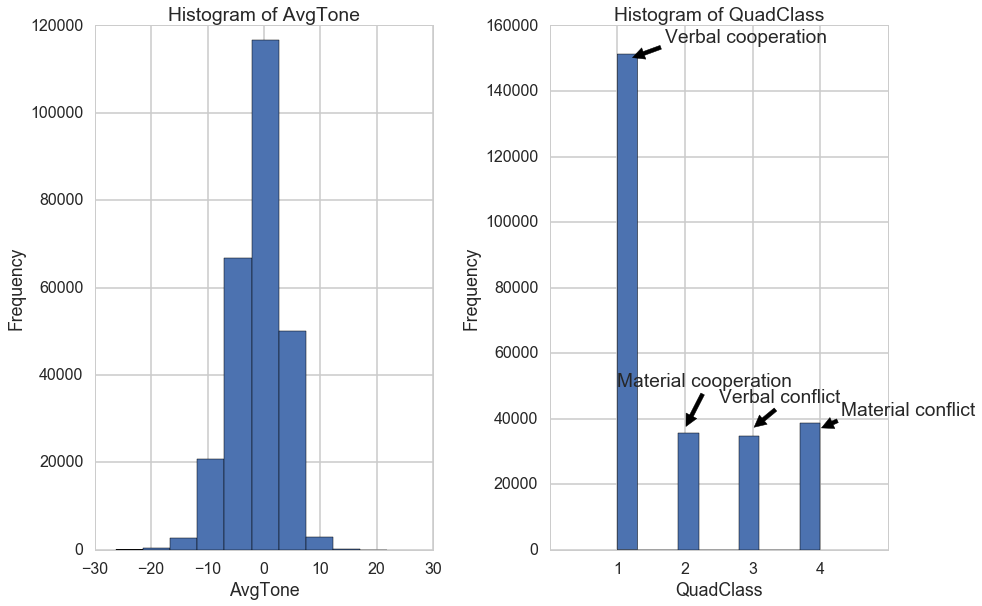

In [2]:
path1 = r'./dataset/' + 'FR' + r'.csv'
DataSet = pd.read_csv(path1, header = 0, index_col = 0, parse_dates = ['SQLDATE', 'DATEADDED'], infer_datetime_format = True)
DataSet.head()

# descriptive statistics
f, ax = plt.subplots(ncols = 2)
ax[0].hist(DataSet['AvgTone'])
ax[0].set_title('Histogram of AvgTone')
ax[0].set_xlabel('AvgTone')
ax[0].set_ylabel('Frequency')

ax[1].hist(DataSet['QuadClass'])
ax[1].set_title('Histogram of QuadClass')
ax[1].set_xlabel('QuadClass')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks([1, 2, 3, 4])
ax[1].set_xlim([0, 5])
ax[1].annotate('Verbal cooperation', xy=([1.2,150000]), xytext=(1.7, 155000), arrowprops=dict(facecolor='black', shrink=0.05))
ax[1].annotate('Material cooperation', xy=([2, 37000]), xytext=(1, 50000), arrowprops=dict(facecolor='black', shrink=0.05))
ax[1].annotate('Verbal conflict', xy=([3, 37000]), xytext=(2.5, 45000), arrowprops=dict(facecolor='black', shrink=0.05))
ax[1].annotate('Material conflict', xy=([4, 37000]), xytext=(4.3, 41000), arrowprops=dict(facecolor='black', shrink=0.05))
f.tight_layout()

The vast majority ov events has a neutral tone and 'verbal cooperation' type.

## Forecasting data

In [3]:
path1 = r'./dataset/' + 'FRTimeSeries1' + r'.csv'
TS = pd.read_csv(path1, header = 0, index_col = 0, parse_dates = ['Date'], infer_datetime_format = True)
TS.head()

# dividing data into training and test sets
l = round(TS.last_valid_index() * 0.95)
TS_train = TS.loc[TS.index[0:l]]
TS_test = TS.loc[TS.index[l:]]
N = len(TS_test)
TS_train.index = TS_train['Date'].values
TS_train = TS_train.drop(['EventCode', 'URL'], 1)

C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\indexes\base.py:1269: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))


### ARIMA

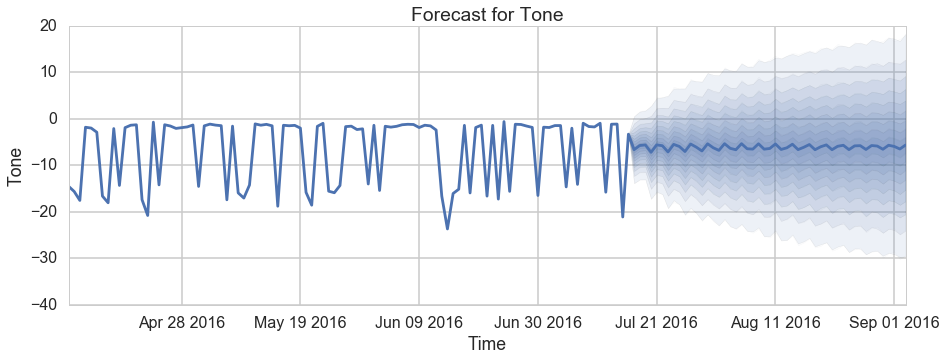

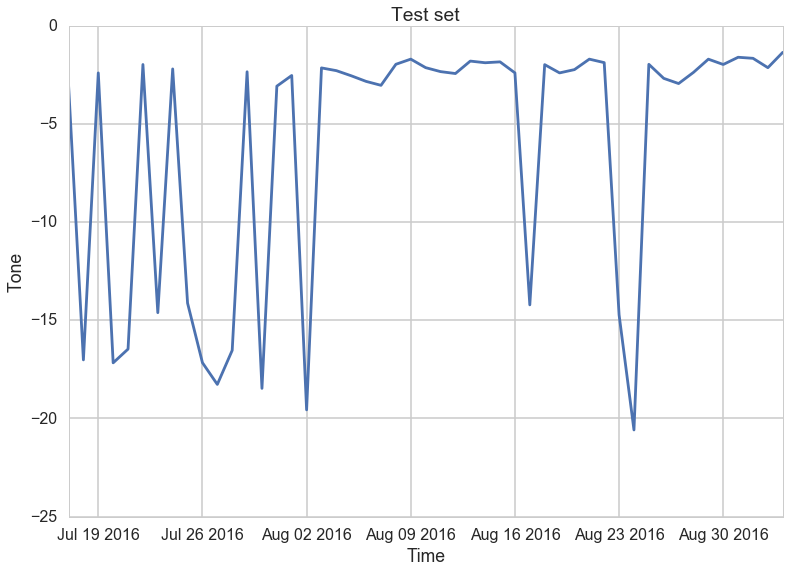

In [34]:
model = pf.ARIMA(data=TS_train,ar=3,ma=4,integ=0, target='Tone')
model.fit('MLE')
model.plot_predict(h=N,past_values=100,figsize=(15,5))
f, ax = plt.subplots()
ax.plot(TS_test['Date'], TS_test['Tone'])
ax.set_title('Test set')
ax.set_xlabel('Time')
ax.set_ylabel('Tone')

In [ ]:
model = pf.DAR(data=TS_train,ar=9,integ=0,target='Tone')
model.fit('MLE')
model.plot_predict(h=N,past_values=100,figsize=(15,5))

In [4]:
pf.ARIMAX?
#model = pf.GAS(data=TS_train, ar=2, sc=2, target='Tone', family=pf.GASPoisson())
#model = pf.GASLLEV(data=TS_train, target='Tone', family=pf.GASPoisson())